In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning

## Suppress warnings

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
DATA_PATH = "./datasets/datasets/generated_sales_dataset.json"

## Load dataset

In [4]:
def load_data(path=DATA_PATH):
    print("Loading data from:", path)
    df = pd.read_json(path, orient="records")
    return df

## Prepare daily aggregated sales & price time series

In [5]:
def prepare_time_series(df, product_code=None):
    if product_code:
        df = df[df['product_code'] == product_code]
    df['buying_date'] = pd.to_datetime(df['buying_date'])
    
    daily_sales = df.groupby('buying_date')['quantity'].sum().sort_index()
    daily_price = df.groupby('buying_date')['unit_price'].mean().sort_index()

    # Ensure daily frequency
    daily_sales = daily_sales.asfreq('D')
    daily_price = daily_price.asfreq('D')

    # Fill NaNs robustly
    daily_sales = daily_sales.fillna(0)
    daily_price = daily_price.fillna(method='ffill').fillna(method='bfill')

    # Drop any residual NaNs
    daily_sales = daily_sales.dropna()
    daily_price = daily_price.dropna()

    return daily_sales, daily_price

## SARIMA forecasting

In [6]:
def sarima_forecast(series, order=(1,1,1), seasonal_order=(1,1,1,7), forecast_days=7):
    series = series.fillna(method='ffill').fillna(0)

    try:
        model = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, maxiter=200, method='powell')
    except Exception as e:
        print(f"SARIMA failed with {order}, {seasonal_order}: {e}. Retrying with simpler model...")
        model = SARIMAX(series, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, maxiter=200, method='powell')

    forecast = model_fit.forecast(steps=forecast_days)

    today = pd.Timestamp.today().normalize()
    forecast_index = pd.date_range(start=today + pd.Timedelta(days=1),
                                   periods=forecast_days, freq='D')
    forecast.index = forecast_index

    return forecast, model_fit

## RMSE calculation

In [7]:
def calculate_rmse(true_values, predicted_values):
    df = pd.DataFrame({'true': true_values, 'pred': predicted_values}).dropna()
    if df.empty:
        return np.nan
    return np.sqrt(mean_squared_error(df['true'], df['pred']))


## Forecast for a single product

In [8]:
def forecast_for_product(df, product_code, forecast_days=7):
    sales_series, price_series = prepare_time_series(df, product_code)
    forecast_sales, model_fit_sales = sarima_forecast(sales_series, forecast_days=forecast_days)
    forecast_price, model_fit_price = sarima_forecast(price_series, forecast_days=forecast_days)

    rmse_sales = calculate_rmse(sales_series[-forecast_days:], forecast_sales) if len(sales_series) >= forecast_days else None
    rmse_price = calculate_rmse(price_series[-forecast_days:], forecast_price) if len(price_series) >= forecast_days else None

    predictions = {}
    for date, sale, price in zip(forecast_sales.index, forecast_sales.values, forecast_price.values):
        predictions[str(date.date())] = {
            "expected_sale_stock": round(float(sale), 2),
            "expected_price": round(float(price), 2)
        }

    return predictions, sales_series, forecast_sales, rmse_sales, price_series, forecast_price, rmse_price


## Forecast for all product codes

In [9]:
def forecast_for_all_products(df, forecast_days=7):
    all_products = df['product_code'].unique()
    results = {}
    for product_code in all_products:
        predictions, sales_series, forecast_sales, rmse_sales, price_series, forecast_price, rmse_price = forecast_for_product(df, product_code, forecast_days)
        for date, metrics in predictions.items():
            if date not in results:
                results[date] = {}
            results[date][product_code] = metrics
    return results


In [10]:
def main():
    df = load_data()

    print("Choose an option:\n1. Prediction for a specific product_code\n2. Prediction for next 7 days for all product codes")
    choice = input("Enter choice (1 or 2): ").strip()

    if choice == '1':
        product_code = input("Enter product_code to predict: ").strip()
        predictions, sales_series, forecast_sales, rmse_sales, price_series, forecast_price, rmse_price = forecast_for_product(df, product_code)

        print(f"\n7-day forecast for product_code: {product_code}")
        print(json.dumps(predictions, indent=4))
        if rmse_sales is not None and rmse_price is not None:
            print(f"RMSE Sales: {rmse_sales:.3f}, RMSE Price: {rmse_price:.3f}")

        # Plot sales
        plt.figure(figsize=(12,5))
        plt.plot(sales_series.index, sales_series.values, label='Historical Sales')
        plt.plot(forecast_sales.index, forecast_sales.values, label='Forecasted Sales', color='red')
        plt.title(f'Sales Forecast for {product_code}')
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.legend()
        plt.show()

        # Plot prices
        plt.figure(figsize=(12,5))
        plt.plot(price_series.index, price_series.values, label='Historical Price')
        plt.plot(forecast_price.index, forecast_price.values, label='Forecasted Price', color='green')
        plt.title(f'Price Forecast for {product_code}')
        plt.xlabel('Date')
        plt.ylabel('Unit Price')
        plt.legend()
        plt.show()

    elif choice == '2':
        results = forecast_for_all_products(df)
        print("\n7-day forecast for all product codes:")
        print(json.dumps(results, indent=4))
    else:
        print("Invalid choice. Exiting.")

Loading data from: ./datasets/datasets/generated_sales_dataset.json
Choose an option:
1. Prediction for a specific product_code
2. Prediction for next 7 days for all product codes


Enter choice (1 or 2):  1
Enter product_code to predict:  S1002


/tmp/ipykernel_338/4208608311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buying_date'] = pd.to_datetime(df['buying_date'])
/tmp/ipykernel_338/4208608311.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_price = daily_price.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_338/1607094272.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method='ffill').fillna(0)
/tmp/ipykernel_338/1607094272.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfil


7-day forecast for product_code: S1002
{
    "2025-10-13": {
        "expected_sale_stock": 1.35,
        "expected_price": 2000.0
    },
    "2025-10-14": {
        "expected_sale_stock": 4.42,
        "expected_price": 2000.0
    },
    "2025-10-15": {
        "expected_sale_stock": 0.48,
        "expected_price": 2000.0
    },
    "2025-10-16": {
        "expected_sale_stock": 1.09,
        "expected_price": 2000.0
    },
    "2025-10-17": {
        "expected_sale_stock": 0.43,
        "expected_price": 2000.0
    },
    "2025-10-18": {
        "expected_sale_stock": 0.72,
        "expected_price": 2000.0
    },
    "2025-10-19": {
        "expected_sale_stock": 1.87,
        "expected_price": 2000.0
    }
}
RMSE Sales: nan, RMSE Price: nan


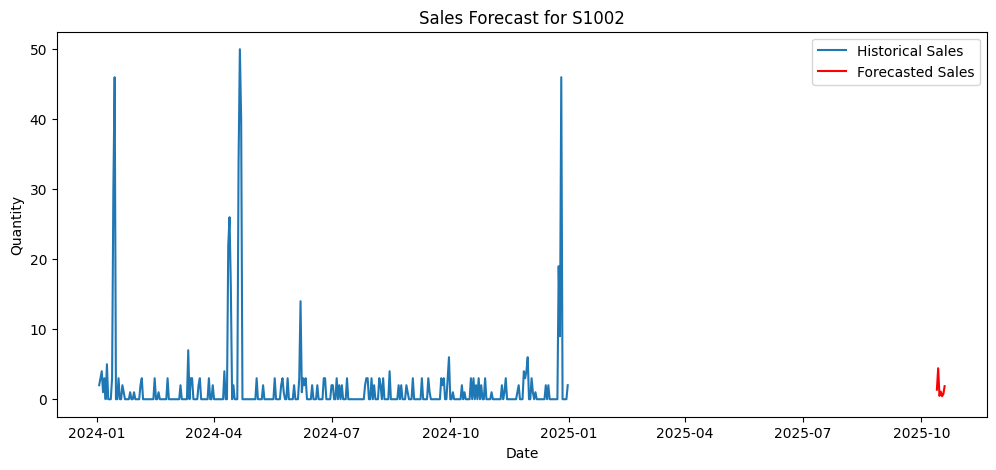

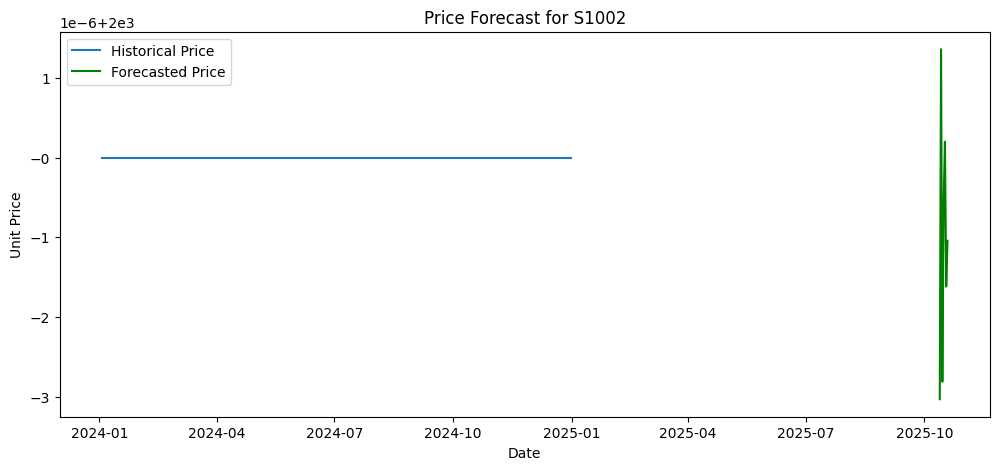

In [11]:
if __name__ == '__main__':
    main()